# Predict interval boundaries on kss audio

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import IPython
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from display import Disp

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Data Preparation
Create features and labels


### Character and Syllable Chunk Markers


In [14]:
from marker_df import MarkerDf
# disp.file_source('marker_df.py', label='marker_df.py ')

chunk_dir = 'data/korean-single-speaker/kss_chunks'

markers_char = MarkerDf.read_csv(f'{chunk_dir}/chunk_char.csv')
markers_syl = MarkerDf.read_csv(f'{chunk_dir}/chunk_syl.csv')

### Event Markers

#### Event Marker Data

In [15]:
disp.obj(markers_char.df, 'Character DataFrame')
disp.obj(markers_char.df.describe(), 'Character DataFrame Statistics')
disp.obj(markers_syl.df, 'Syllable DataFrame')
disp.obj(markers_syl.df.describe(), 'Syllable DataFrame Statistics')


Character DataFrame

,char,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,ᄀ,0.14298,0.17326,data/korean-single-speaker/kss/1/1_0000.wav
2,ᅳ,0.17326,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
3,ᆫ,0.25143,0.30110,data/korean-single-speaker/kss/1/1_0000.wav
4,ᅳ,0.30110,0.39456,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
144,ᆫ,0.80030,0.84911,data/korean-single-speaker/kss/1/1_0004.wav
145,~ᆫ호,0.84911,0.89335,data/korean-single-speaker/kss/1/1_0004.wav
146,아,0.89335,1.00634,data/korean-single-speaker/kss/1/1_0004.wav
147,ᆯ,1.00634,1.06034,data/korean-single-speaker/kss/1/1_0004.wav


Character DataFrame Statistics

,start,stop
count,149.000000,149.000000
mean,1.323329,1.408087
std,0.986901,0.998032
min,0.000000,0.042620
25%,0.516890,0.592430
50%,1.074710,1.128250
75%,2.048690,2.155180
max,3.713270,3.972180


Syllable DataFrame

,syl,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,그,0.14298,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
2,는,0.25143,0.49473,data/korean-single-speaker/kss/1/1_0000.wav
3,0,0.49473,0.52397,data/korean-single-speaker/kss/1/1_0000.wav
4,괜,0.52397,0.71846,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
77,~ᆫ화,0.56929,0.67854,data/korean-single-speaker/kss/1/1_0004.wav
78,번,0.67854,0.84911,data/korean-single-speaker/kss/1/1_0004.wav
79,~ᆫ호,0.84911,0.89335,data/korean-single-speaker/kss/1/1_0004.wav
80,알,0.89335,1.06034,data/korean-single-speaker/kss/1/1_0004.wav


Syllable DataFrame Statistics

,start,stop
count,82.000000,82.000000
mean,1.249581,1.403593
std,0.989029,1.015257
min,0.000000,0.042620
25%,0.490613,0.600592
50%,1.012760,1.149960
75%,1.765813,2.064005
max,3.713270,3.972180


#### Intervals

In [16]:
disp.obj(markers_char.intervals(), 'Char Intervals')
disp.obj(markers_char.intervals().describe(), 'Char Interval statistics')
disp.obj(markers_syl.intervals().describe(), 'Syl Intervals')
disp.obj(markers_syl.intervals().describe(), 'Syl Interval statistics')

Char Intervals

0      0.14298
1      0.03028
2      0.07817
3      0.04967
4      0.09346
        ...   
144    0.04881
145    0.04424
146    0.11299
147    0.05400
148    0.00342
Length: 149, dtype: float64

Char Interval statistics

count    149.000000
mean       0.084759
std        0.059595
min        0.003420
25%        0.044530
50%        0.072780
75%        0.109250
max        0.312600
dtype: float64

Syl Intervals

count    82.000000
mean      0.154012
std       0.079927
min       0.003420
25%       0.093190
50%       0.145810
75%       0.213890
max       0.336930
dtype: float64

Syl Interval statistics

count    82.000000
mean      0.154012
std       0.079927
min       0.003420
25%       0.093190
50%       0.145810
75%       0.213890
max       0.336930
dtype: float64

### Features and Labels

Informational:
* Consonant Phonemes duration 25-50 msec
* Vowel Phonemes duration 50-100+ msec

#### Labels

True/False  Speech/No Speech

#### Features

Base waveform: RMS calculation (via librosa) of audio wav file
This significantly reduces the feature space with little impact to learning

Features are a sliding window on the base RMS waveform.

#### Mapping Label to Feature

It's easier to understand visually:

For a Sliding Window size = 16
```
     Sliding Window[6]           sliding_window[6].shape = (16,)
 012345 6789012345678901 2345678  index visualization
 ------|----------------|-------  waveform
                   |
                   V              y-offset = 11
 000000 0000000011111111 1111000  speech/no speech labels
                   1              label corresponding to sliding_window[6] -> label[17]


Mapping of sliding window to label
sliding_window[0]  -> 0 label[11]
sliding_window[1]  -> 0 label[12]
sliding_window[2]  -> 1 label[13]
sliding_window[3]  -> 1 label[14]
sliding_window[4]  -> 1 label[15]
sliding_window[5]  -> 1 label[16]
sliding_window[6]  -> 1 label[17]
sliding_window[7]  -> 1 label[18]
...
sliding_window[11] -> 1 label[24]
sliding_window[12] -> 1 label[25]
sliding_window[13] -> 0 label[26]
sliding_window[14] -> 0 label[27]
...
```

For our speech analysis, what comes after does have an effect on the present, but the past has more of
an impact. So say for this example, we look behind 11 points, and look ahead 4 points. This gives us a total window
size of 16 points (since we include our current point). So our sliding window has a size of 16.

So for the very first sliding window,

`window[0]` has `waveform[0:15]` and the associated label is `label[11]` -> `0 [Speech Not Present]`.

As we continue to slide the window, say 6 more times,

`window[6]` -> `waveform[17]` -> `label[17]` -> `1 [Speech Present]`.

This will generate our `y` that we want the window data to predict. So

```
X (feature)                 |  y (label)
window[0] = waveform[0:16]  |  y[0] = label[11] = 0
window[1] = waveform[1:17]  |  y[1] = label[12] = 0
window[2] = waveform[2:18]  |  y[2] = label[13] = 1
window[3] = waveform[3:19]  |  y[3] = label[14] = 1
window[4] = waveform[4:20]  |  y[4] = label[15] = 1
...
```

Note that the `y` we predict will be offset from the actual waveform by our "look behind" of 11 points. This is
the "y-offset". So later after we predict `y`, we will need to shift it by `y-offset` to align it with the
original labels and waveform.

### Feature Prep and Inspection

Generate the Feature data (X)

In [17]:
## Uncomment to investigate Audio class
##   Audio is wrapped by AudioPlexer, and AudioPlexer is the main interface
# from audio import Audio
# disp.code('audio.py', label='audio.py ')
#
# audio_path_ = 'data/korean-single-speaker/kss/1/1_0000.wav'
#
# a = Audio(audio_path_, n_fft=256, n_hops=4, n_mfcc=3)
#
# # plotting
# fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(18,12))
# fig.suptitle('X', fontsize=16)
#
# ax1.set_title(f'Wav size={a.size} sr={a.sr}\nRMS size={len(a.rms.flatten())} frame_length={a.n_fft} hop_length={a.hop_length}\n')
# ax1.plot(a.wav, color='slategray', alpha=0.6, label='wav')
#
# ax1a = ax1.twiny()
# ax1a.plot(a.rms.flatten(), color='cyan', alpha=0.6, label='rms')
# ax1.legend(loc='lower right')
# ax1a.legend(loc='upper right')
#
# ax2.set_title(f'MFCC and RMS')
# ax2.plot(a.rms.flatten(), color='slategray', alpha=0.6, label='rms')
# ax2.legend(loc='center left')
#
# ax2a = ax2.twinx()
# ax2a.plot(a.mfcc[0], color='cyan', alpha=0.6, label='mfcc 0')
# ax2a.plot(a.mfcc[1], color='lightblue', alpha=0.6, label='mfcc 1')
# ax2a.plot(a.mfcc[2], color='steelblue', alpha=0.6, label='mfcc 2')
# ax2a.legend(loc='center right')
#
# plt.show()

#### AudioPlexer Usage and Inspection

AudioPlexer will be used to generate the Feature (X) data.
Here we just see what it's doing.

/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


a.to_rms size: 2430, reduced 2429.984375
wav shape: (155519,)
rms shape: (2430,)
mfcc shape: (8, 2430)
sliding windows shape: (2383, 48)


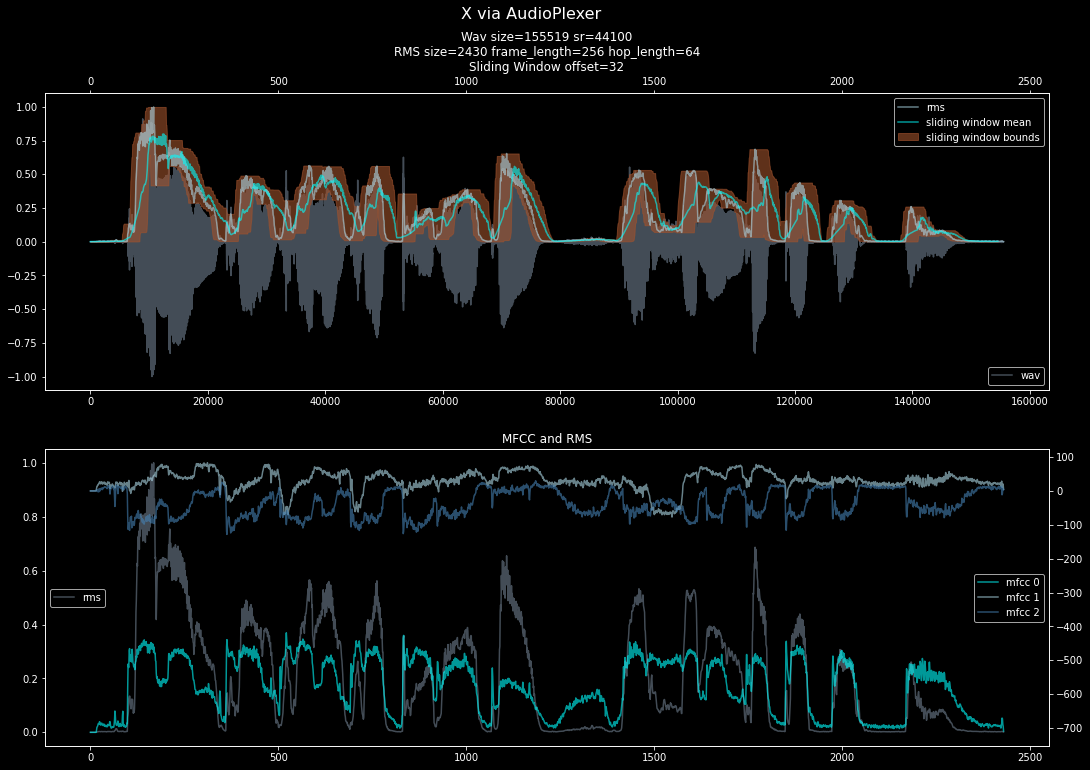

In [18]:
from audio_plexer import AudioPlexer
# disp.code('audio_plexer.py', label='audio_plexer.py ')



audio_paths_ = ['data/korean-single-speaker/kss/1/1_0000.wav']
ap_params_example = {
    'n_fft': 256,
    'n_hops':  4,
    'sliding_window_size': 48,
    'sliding_offset': 32
}
ap = AudioPlexer(audio_paths_, **ap_params_example)

ap_rms = ap.rms().flatten()
ap_mfcc = ap.mfcc()
ap_windows, _ = ap.sliding_window_features(ap_rms)

print(f'wav shape: {ap.wav().shape}')
print(f'rms shape: {ap_rms.shape}')
print(f'mfcc shape: {ap_mfcc.shape}')
print(f'sliding windows shape: {ap_windows.shape}')


# plotting
align_ap_windows = np.pad(ap_windows, (ap.sliding_offset, 0), 'edge')
fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(18,12))
fig.suptitle('X via AudioPlexer', fontsize=16)

ax1.set_title(f'Wav size={ap.size} sr={ap.sr}\nRMS size={len(ap_rms)} frame_length={ap.n_fft} hop_length={ap.hop_length}\nSliding Window offset={ap.sliding_offset}')
ax1.plot(ap.wav(), color='slategray', alpha=0.6, label='wav')

ax1a = ax1.twiny()
ax1a.plot(ap_rms, color='lightblue', alpha=0.6, label='rms')
ax1a.plot(np.mean(align_ap_windows, axis=1), color='cyan', alpha=0.6, label=f'sliding window mean')
ax1a.fill_between(range(align_ap_windows.shape[0]),
                  np.min(align_ap_windows, axis=1), np.max(align_ap_windows, axis=1),
                  color='sienna', alpha=0.6, label='sliding window bounds')
ax1.legend(loc='lower right')
ax1a.legend(loc='upper right')

ax2.set_title(f'MFCC and RMS')
ax2.plot(ap_rms, color='slategray', alpha=0.6, label='rms')
ax2.legend(loc='center left')

ax2a = ax2.twinx()
ax2a.plot(ap_mfcc[0], color='cyan', alpha=0.6, label='mfcc 0')
ax2a.plot(ap_mfcc[1], color='lightblue', alpha=0.6, label='mfcc 1')
ax2a.plot(ap_mfcc[2], color='steelblue', alpha=0.6, label='mfcc 2')
ax2a.legend(loc='center right')

plt.show()

## Training

### Generate Training Features

Generate Training Features to be used for training our model

TODO: Incorporate MFCCs

In [19]:
training_files= markers_syl.df['audio'].unique()

In [20]:
from audio_plexer import AudioPlexer


ap_params_train = {
    'n_fft': 256,
    'n_hops':  4,
    'sliding_window_size': 48,
    'sliding_offset': 32
}
ap = AudioPlexer(training_files, **ap_params_train)

print(f'all audio length (wav samples) {ap.size}, duration: {ap.size/ap.sr}')
ap_rms = ap.rms().flatten()

is_speech_wav = ap.val_from_interval(markers_syl.df, missing_val=False, val_col='syl')
is_speech_rms = ap.to_rms(is_speech_wav.astype(float)).flatten()


print(f'wav shape: {ap.wav().shape}')
print(f'wav rms shape: {ap_rms.shape}')
print(f'is_speech_wav shape: {is_speech_wav.shape}')
print(f'is_speech_rms shape: {is_speech_rms.shape}')



/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[WARNING]: Modifying input wav from size 175173 to 175168
Audio[INFO]: change in number of samples: -5 [should be less than hop length: 64]
Audio[WARNING]: Modifying input wav from size 77573 to 77568
Audio[INFO]: change in number of samples: -5 [should be less than hop length: 64]
Audio[WARNING]: Modifying input wav from size 101762 to 101760
Audio[INFO]: change in number of samples: -2 [should be less than hop length: 64]
Audio[WARNING]: Modifying input wav from size 58741 to 58688
Audio[INFO]: change in number of samples: -53 [should be less than hop length: 64]
/Users/dev/Projects/korean-ml/audio_plexer.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

a.to_rms size: 2430, reduced 2429.984375
a.to_rms size: 2737, reduced 2736.984375
a.to_rms size: 1212, reduced 1211.984375
a.to_rms size: 1590, reduced 1589.984375
a.to_rms size: 917, reduced 916.984375
all audio length (wav samples) 568699, duration: 12.895668934240362
wav shape: (568699,)
wav rms shape: (8886,)
is_speech_wav shape: (568699,)
is_speech_rms shape: (8886,)


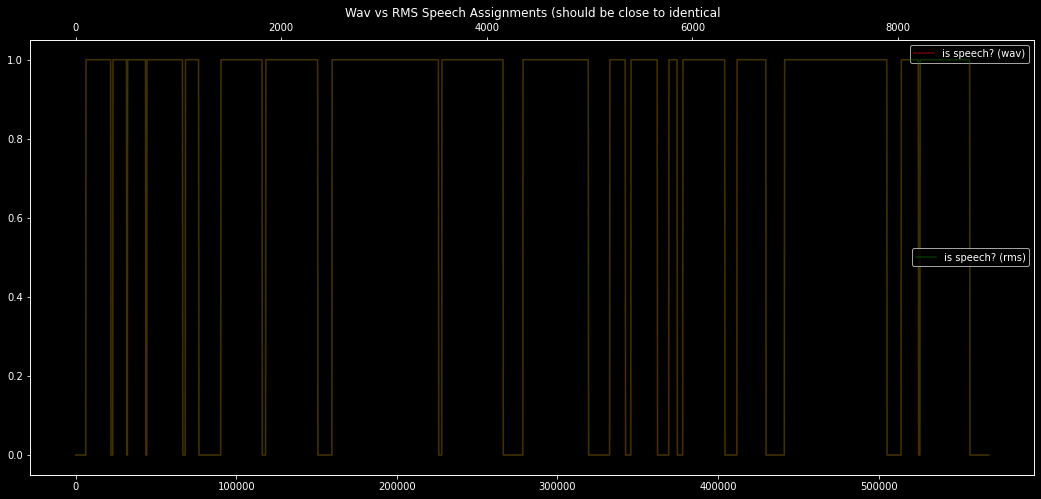

In [21]:
# TODO: Add wav and rms to this plot
fig, ax1  = plt.subplots(1, 1, figsize=(18,8))
# fig.suptitle('RMS X and y', fontsize=14)

ax1.set_title(f'Wav vs RMS Speech Assignments (should be close to identical')
ax1.plot(is_speech_wav.astype(float), color='red', alpha=0.4, label='is speech? (wav)')
ax1.legend(loc='upper right')
ax1a = ax1.twiny()
ax1a.plot(is_speech_rms, color='green', alpha=0.4, label='is speech? (rms)')
ax1a.legend(loc='center right')

plt.show()

In [22]:
# TODO: Use these functions to create and assign value column (as float) rather than in the Audio* classes
def filter_to_basics(full_df, filter_on_path):
    return full_df.loc[full_df['audio'] == filter_on_path,['start', 'stop', 'syl', 'audio']]

def flag_speech(df):
    df['value'] = df['syl'] != '0'
    return df

def speech_events(full_df, audio_path):
    return flag_speech(filter_to_basics(full_df, audio_path))

In [23]:
# TODO: Tune for these
sw_size = 128 # 128//2
sw_offset = 64 # 96//2
X_train, y_train = ap.sliding_window_features(ap_rms, y=is_speech_rms, window=sw_size, offset=sw_offset)

### Train Model: SVR (Support Vector Regression)

Train SVR and evaluate against training set

This is to verify the algorithms are working.
Validation is onde manually and will come later.

### Using sliding window over RMS of wav

In [24]:
from sklearn.svm import SVR
# from sklearn.svm import SVC
# from sklearn.preprocessing import Binarizer
# from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
# from pipegraph.base import PipeGraph
from sklearn.model_selection import GridSearchCV


In [25]:
# Hyperparameters

# best params
# 'svr__degree': [2, 3, 4], # not used for rbf
# 'svr__kernel': ['rbf'] out of ['rbf', 'poly', 'linear'],
# 'svr__gamma': ['auto'] # out of [0.1, 'scale', 'auto'], BUT, hand tuning seems to work better
param_grid = {
    # svr
    'svr__kernel': ['rbf'],
    'svr__C': [50],
    'svr__gamma': [0.2],
    'svr__epsilon': [0.1],
    'svr__verbose': [3],
    #svc
    # 'svc__kernel': ['rbf'],
    # 'svc__C': [50],
    # 'svc__gamma': [0.2],
    # 'svc__verbose': [3]
}

# Models and processing
svr_rbf = SVR()
# svc_rbf = SVC()

steps = [('svr', svr_rbf)]

pipe = Pipeline(steps=steps)

search = GridSearchCV(pipe, param_grid, n_jobs=-2)

search.fit(X_train, y_train)
print(search.best_params_)
y_train_pred = search.predict(X_train)

[LibSVM]{'svr__C': 50, 'svr__epsilon': 0.1, 'svr__gamma': 0.2, 'svr__kernel': 'rbf', 'svr__verbose': 3}


### Evaluate Training

Evaluate the training data by seeing if our trained model will predict close to the data it was trained on.

Validation will come later

This is just to make sure our Model trained correctly. It might have overfit, but we don't care yet.

In [26]:
# TODO: Move these into a class
def pred_threshold(pred_vals, thresh=0.5):
    return np.where(pred_vals > thresh, True, False)


def get_events_from_preds(preds):
    pred_pad = np.pad(preds, (0,0), 'minimum')


# y_svr_pred = pred_threshold(y_train_pred, 0.5)
y_train_pred_bool = pred_threshold(y_train_pred, 0.5)

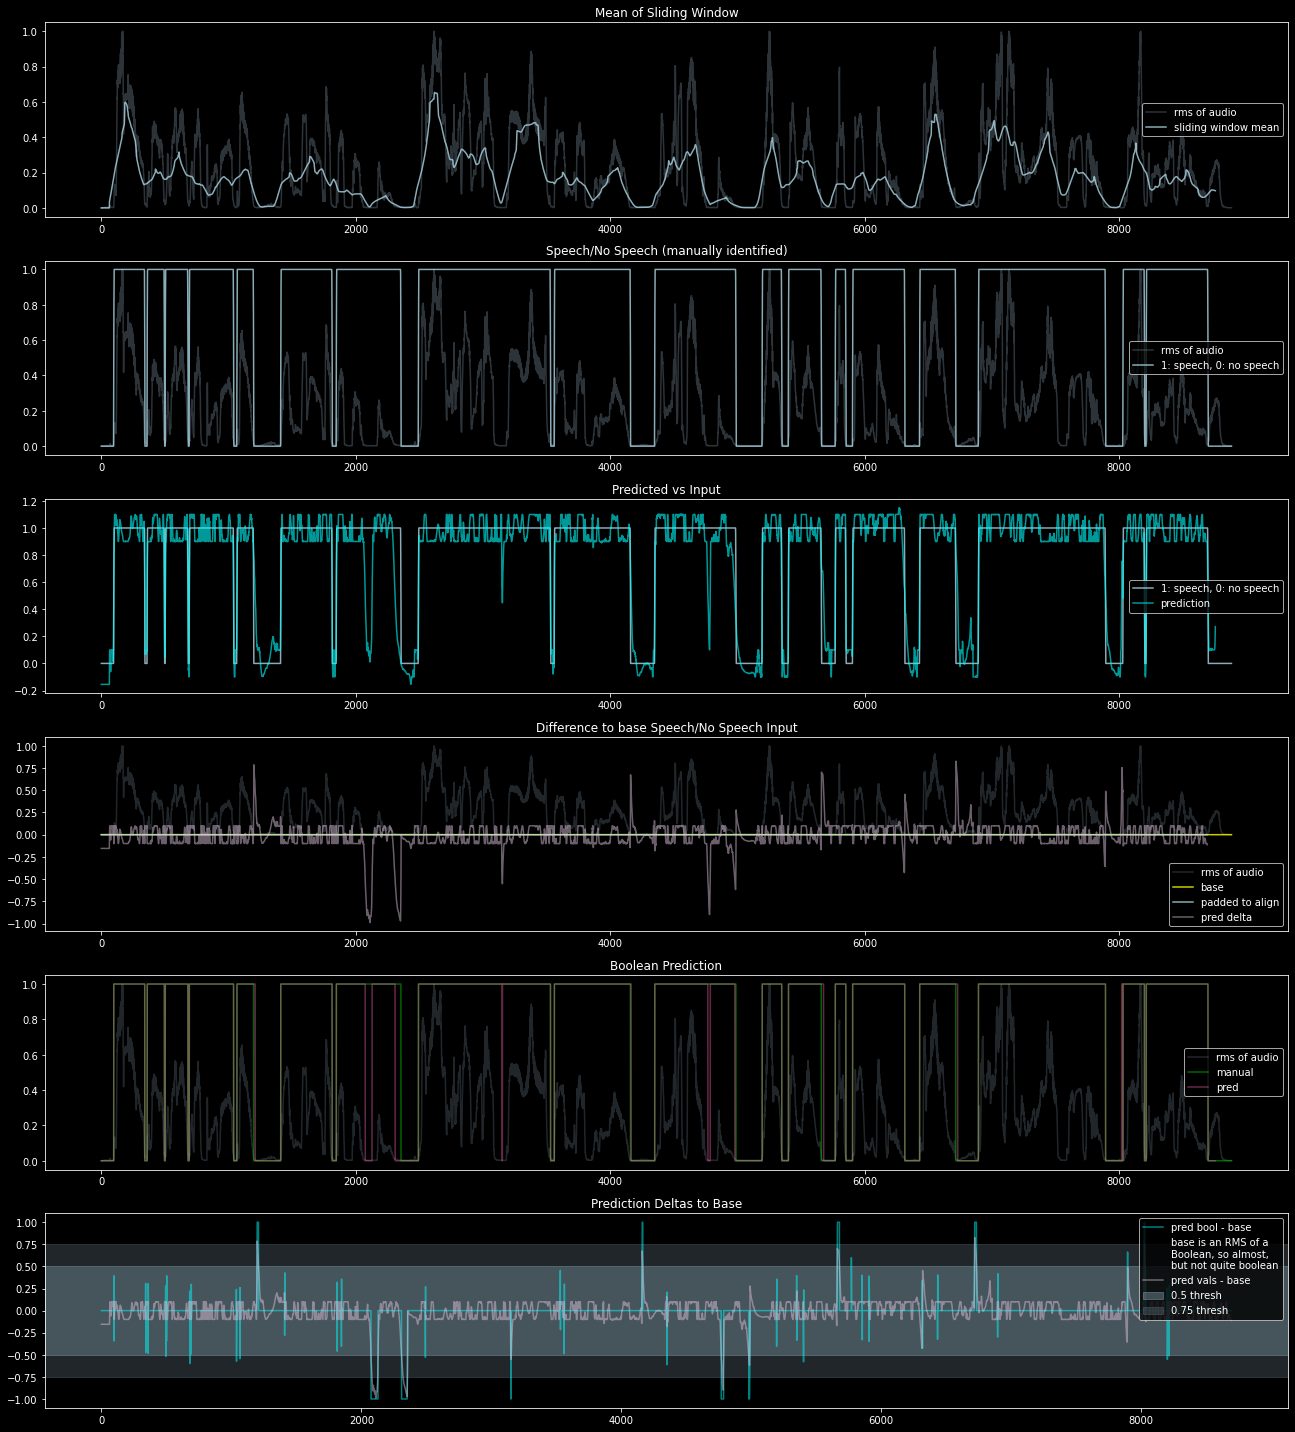

In [29]:
def align(y, offset):
    return np.pad(y, (offset, 0), 'minimum')

def delta(y1, y2, y1_offset, y2_offset):
    min_len = min(len(y1), len(y2))
    return align(y1, y1_offset)[0:min_len] - align(y2, y2_offset)[0:min_len]

def speech_base_delta(y, offset):
    return delta(y, is_speech_rms, offset, 0)


fig, axs  = plt.subplots(6, 1, figsize=(18,20))
# fig.suptitle('RMS X and y', fontsize=14)

axs[0].set_title(f'Mean of Sliding Window')
axs[0].plot(ap_rms, color='slategray', alpha=0.4, label='rms of audio')
axs[0].plot(np.mean(align(X_train, sw_offset), axis=1), color='lightblue', alpha=0.8, label='sliding window mean')
axs[0].legend(loc='center right')

axs[1].set_title(f'Speech/No Speech (manually identified)')
axs[1].plot(ap_rms, color='slategray', alpha=0.4, label='rms of audio')
axs[1].plot(is_speech_rms, color='lightblue', alpha=0.8, label='1: speech, 0: no speech')
axs[1].legend(loc='center right')

axs[2].set_title(f'Predicted vs Input')
axs[2].plot(is_speech_rms, color='lightblue', alpha=0.8, label='1: speech, 0: no speech')
axs[2].plot(align(y_train_pred, sw_offset), color='cyan', alpha=0.6, label='prediction')
axs[2].legend(loc='center right')

axs[3].set_title(f'Difference to base Speech/No Speech Input')
axs[3].plot(ap_rms, color='slategray', alpha=0.3, label='rms of audio')
axs[3].plot(is_speech_rms-is_speech_rms, color='yellow', alpha=0.8, label='base')
axs[3].plot(speech_base_delta(y_train, sw_offset), color='lightblue', alpha=0.8, label="padded to align")
axs[3].plot(speech_base_delta(y_train_pred, sw_offset), color='thistle', alpha=0.5, label='pred delta')
axs[3].legend(loc='lower right')

axs[4].set_title(f'Boolean Prediction')
axs[4].plot(ap_rms, color='slategray', alpha=0.3, label='rms of audio')
axs[4].plot(1*pred_threshold(is_speech_rms, 0.5), color='lime', alpha=0.4, label='manual')
axs[4].plot(align(1*y_train_pred_bool, sw_offset), color='hotpink', alpha=0.4, label='pred')
axs[4].legend(loc='center right')

axs[5].set_title(f'Prediction Deltas to Base')
axs[5].plot(delta(1*y_train_pred_bool, is_speech_rms, sw_offset, 0), color='cyan', alpha=0.5, label='pred bool - base')
axs[5].plot([], [], ' ', label='base is an RMS of a\nBoolean, so almost,\nbut not quite boolean')
axs[5].plot(speech_base_delta(y_train_pred, sw_offset), color='thistle', alpha=0.5, label='pred vals - base')
axs[5].axhspan(-0.5, 0.5, color='lightblue', alpha=0.3, label='0.5 thresh'),
axs[5].axhspan(-0.75, 0.75, color='slategray', alpha=0.3, label='0.75 thresh')
axs[5].legend(loc='upper right')


# axs[1].grid(alpha=0.5)
# ax2.xaxis.set_ticks(np.arange(0, len(y_svr_pts), 400))
plt.tight_layout()
plt.show()


# TODO: Ensemble methods

## Validation

### Predictions on Never Before Seen Data

In [9]:
kss_id = "1/1_0004"
tg_dir = 'data/korean-single-speaker/kss'
val_paths = [f'{tg_dir}/{kss_id}.wav']
ap_params_val = ap_params_train

#TODO: We will operate on single files so we should use Audio not AudioPlexer
# AudioPlexer: n audio files -> 1 TextGrid
# Audio: n audio files -> n TextGrids
ap = AudioPlexer(val_paths, **ap_params_val)

disp.audio(data=ap.wav(), rate=ap.sr)

ap_rms = ap.rms().flatten()
X_val, _ = ap.sliding_window_features(ap_rms, y=is_speech_rms, window=sw_size, offset=sw_offset)
y_val = search.predict(X_val)

fig, ax1  = plt.subplots(1, 1, figsize=(18,5))

y_val_bool = pred_threshold(y_val, 0.5)
ax1.set_title(f'Predicted Speech for Validation Data')
ax1.plot(ap_rms, color='lightblue', alpha=0.8, label='rms')
ax1.plot(align(y_val, sw_offset), color='cyan', alpha=0.6, label='speech prediction')
ax1.plot(align(1*y_val_bool, sw_offset), color='hotpink', alpha=0.5, label='pred to boolean')
ax1.legend(loc='center right')


plt.show()

Audio[WARNING]: Modifying input wav from size 58741 to 58688
Audio[INFO]: change in number of samples: -53 [should be less than hop length: 64]
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


a.to_rms size: 917, reduced 916.984375


NameError: name 'is_speech_rms' is not defined

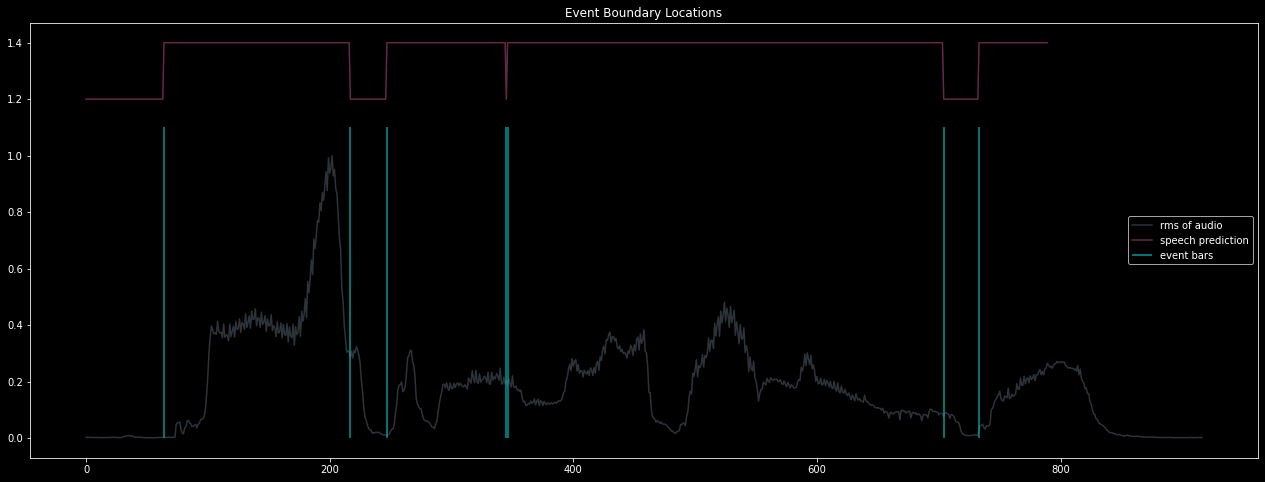

[0.         0.09287982 0.31492063 0.35845805 0.50068027 0.50213152
 1.021678   1.06376417]


In [74]:
#TODO: Figure out where to do final alignment
# y_train_pred_bool_align = align(y_train_pred_bool, sw_offset)
y_val_bool_align = align(y_val_bool, sw_offset)

# TODO: Move these to a class
def get_interval_idx(bs_in):
    bs = np.pad(bs_in, (1,1), 'edge')
    d = np.diff(bs)
    return np.where(d > 0)[0]


y_val_event_idxs = get_interval_idx(y_val_bool_align)


fig, axs_  = plt.subplots(1, 1, figsize=(22,8), squeeze=False)
axs = axs_[:,0]
axs[0].set_title(f'Event Boundary Locations')
axs[0].plot(ap_rms, color='slategray', alpha=0.4, label='rms of audio')
axs[0].plot(align(0.2*y_val_bool+1.2, sw_offset), color='hotpink', alpha=0.4, label='speech prediction')
axs[0].vlines(y_val_event_idxs, 0, 1.1, color='cyan', alpha=0.6, label="event bars")
axs[0].legend(loc='center right')
# axs[0].plot(delta(1*y_svr_pred, y_base, sw_offset, 0), color='cyan', alpha=0.5, label='pred bool - base')
plt.show()


y_val_event_t = y_val_event_idxs  * (ap.hop_length/ap.sr)
# add start event at t=0
# TODO: add end event at t=? (maybe ok to just add end padding??)
speech_event_t = np.pad(y_val_event_t, (1, 0), constant_values=0.0)
print(speech_event_t)

In [76]:
tg_path = f'{tg_dir}/{kss_id}.pred.TextGrid'

# audio_path = f'{tg_dir}/{audio_file}'
# tg = textgrid.TextGrid.fromFile(tg_path)

# TODO: This really needs to be a class as it should only be one per file.
import string
from pathlib import Path

def make_textgrid(src):
    ivl_template = string.Template(Path('./template/interval.template').read_text())
    item_template = string.Template(Path('./template/item.template').read_text())
    item_list_template = string.Template(Path('./template/itemlist.template').read_text())
    textgrid_template = string.Template(Path('./template/textgrid.template').read_text())

    item_lists_a = []
    for (item_idx, (item_name, event_t)) in enumerate(src):
        ivls_a = []
        # we're going to be taking pairs of data, so skip the last iteration
        ivls_size = len(event_t) - 1
        for i in range(ivls_size):
            ivl_dict = {
                'ivl_id': i+1,
                'ivl_xmin': event_t[i],
                'ivl_xmax': event_t[i+1],
                'ivl_text': ''
            }
            ivls_a.append(ivl_template.substitute(ivl_dict))

        ivls = '\n'.join(ivls_a)

        item_dict = {
            'item_name': item_name,
            'item_xmin': min(event_t),
            'item_xmax': max(event_t),
            'item__intervals_size': ivls_size,
            'item__intervals': ivls
        }
        item = item_template.substitute(item_dict)

        item_list_dict = {
            'item_list_id': item_idx+1,
            'item_list__items': item
        }
        item_lists_a.append(item_list_template.substitute(item_list_dict))

    item_lists = '\n'.join(item_lists_a)
    textgrid_dict = {
        'textgrid_xmin': min(event_t),
        'textgrid_xmax': max(event_t),
        'textgrid_size': len(item_lists_a),
        'textgrid__item_list': item_lists
    }
    return textgrid_template.substitute(textgrid_dict)

def save_textgrid(src, tg_path):
    with open(tg_path, 'w') as f:
        print(f'saving textgrid to {tg_path}')
        f.write(make_textgrid(src))

textgrid_src = [('char', speech_event_t), ('syl', speech_event_t)]
save_textgrid(textgrid_src, tg_path)


saving textgrid to data/korean-single-speaker/kss/1/1_0004.TextGrid
